##**Análisis y predicciones sobre una red de comunicación entre investigadores a través de correos electrónicos**
### Descripción
En el siguiente artículo buscamos analizar una red real de correos electrónicos de una institución de investigación europea, aplicando varias técnicas de network science y machine learning para encontrar características del grafo y medidas de centralidad con el fin de entender mejor la red y luego lograr predecir algunas propiedades usando Representation Learning con Node2Vec  sobre los nodos y arcos que la forman la red.



In [ ]:
!pip install node2vec
!pip install tqdm
!pip install sklearn

In [ ]:
import os
import multiprocessing
import warnings
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from math import isclose
from collections import Counter
from zipfile import ZipFile
from warnings import simplefilter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn import metrics

from node2vec import Node2Vec
from tqdm import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

##Load the data

In [ ]:
edges_csv_emails = pd.read_csv('sample_data/email.csv')
edges_csv_emails['from'].apply(str)
edges_csv_emails['to'].apply(str)
edges_csv_emails = edges_csv_emails.applymap(str)
edges_csv_emails

,from,to
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7
...,...,...
25566,420,143
25567,174,859
25568,440,460
25569,52,786


In [ ]:
department_df = pd.read_csv('sample_data/department.csv')
department_data = dict(department_df.values)
print("Loading data into a dict")
department_df

Loading data into a dict


,node,department
0,0,1
1,1,1
2,2,21
3,3,21
4,4,21
...,...,...
1000,1000,4
1001,1001,21
1002,1002,1
1003,1003,6


In [ ]:
G = nx.from_pandas_edgelist(edges_csv_emails, "from", "to", create_using=nx.DiGraph())

In [ ]:
def get_pos(G):
  return nx.fruchterman_reingold_layout(G, k=1/2)


In [ ]:
pos = get_pos(G)

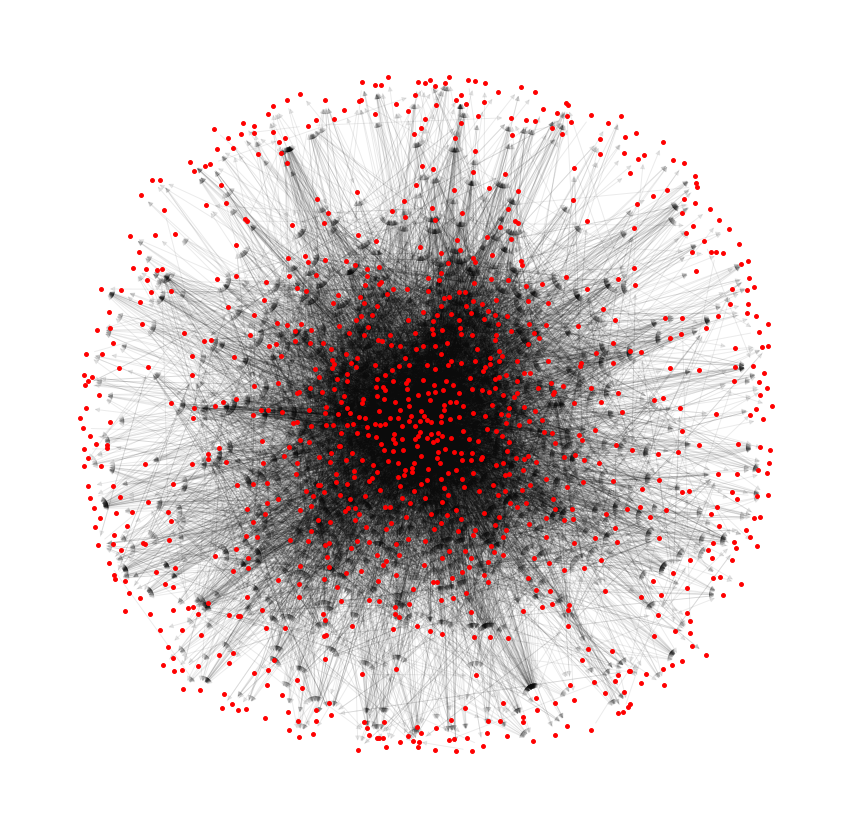

In [ ]:
plt.figure(figsize=(15,15))
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=15, node_color="red")
nx.draw_networkx_edges(G, pos, alpha=0.08)
plt.show()

In [ ]:
rlabels = ('Nodes', 'Edges', 'Is directed', 'Degree assortativity coefficient', 'average clustering', 'Is strongly connected', 'Is directed acyclic graph', 'Is weighted')
data = (f'{len(G.nodes)}',
        f'{len(G.edges)}',
        f'{nx.is_directed(G)}',
        f'{nx.degree_assortativity_coefficient(G):.4f}',
        f'{nx.average_clustering(G):.4f}',
        f'{nx.is_strongly_connected(G)}',
        f'{nx.is_directed_acyclic_graph(G)}',
        f'{nx.is_weighted(G)}',
)

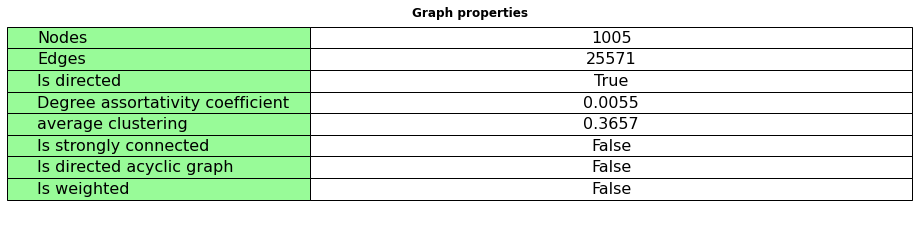

In [ ]:
data = np.array(data).reshape(len(data),1)
fig, ax = plt.subplots()
ax.set_axis_off() 
table = ax.table(
        cellText = data, 
        rowLabels = rlabels, 
        rowColours =["palegreen"] * 10,
        cellLoc ='center',  
        loc ='upper left')
table.set_fontsize(16)
table.scale(1.8, 1.8)
ax.set_title('Graph properties', fontweight ="bold")
plt.show()

## Centrality Measures
### Centrality degree

min degree: 0.00099601593625498, max degree: 0.5438247011952191


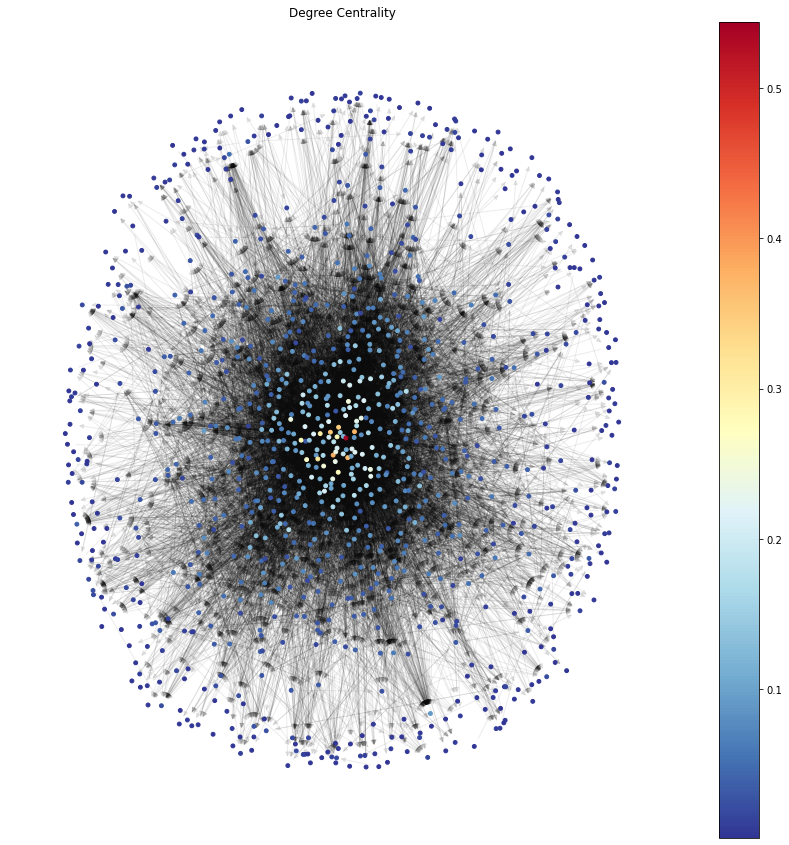

In [ ]:
degree_centrality = list(nx.degree_centrality(G).values())
print(f'min degree: {min(degree_centrality)}, max degree: {max(degree_centrality)}')
plt.figure(figsize=(15,15))
nc = nx.draw_networkx_nodes(G, pos, node_size=15, cmap=plt.cm.RdYlBu_r,
                        node_color=degree_centrality)
nx.draw_networkx_edges(G, pos, alpha=0.08)
plt.title('Degree Centrality')
plt.axis('off')
plt.colorbar(nc);

[0.3545816733067729, 0.36752988047808766, 0.3715139442231076, 0.37749003984063745, 0.5438247011952191]


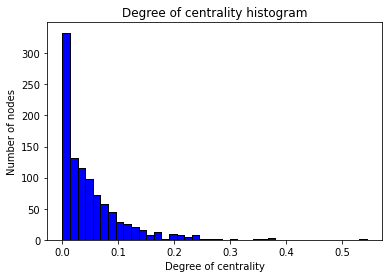

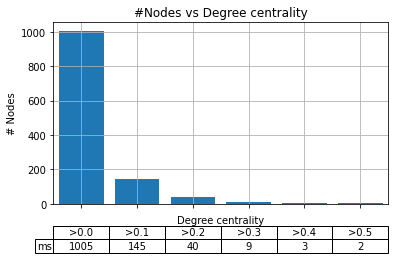

In [ ]:

plt.hist(degree_centrality, color = 'blue', edgecolor = 'black',
         bins = 40)

# Add labels
plt.title('Histogram of degree of centrality')
plt.xlabel('Number of nodes')
plt.ylabel('Degree of centrality')


plt.hist(degree_centrality, color = 'blue', edgecolor = 'black',
         bins = 40)

# Add labels
plt.title('Degree of centrality histogram')
plt.ylabel('Number of nodes')
plt.xlabel('Degree of centrality')



results = {}
acum = 0
target = 0.5
s_degree_centrality= sorted(degree_centrality)
print(s_degree_centrality[-5:])
for i in range(len(s_degree_centrality)-1, -1, -1):
  v = s_degree_centrality[i]
  if v <= target:
    acum += 1
    results[">"+str(round(target, 2))] = acum
    target -= 0.1
  else:
    acum += 1
  if v < 0:
    break

results[">0.0"] = acum;

N = len(results)
colLabels = sorted(results.keys())
fig,ax = plt.subplots()
aa = ax.bar(range(N),[results[x] for x in colLabels],
                    align='center')
ax.set_xlabel('Degree centrality')
ax.set_ylabel('# Nodes')
ax.set_xticklabels([]) # turn off x ticks
ax.grid(True)

fig.subplots_adjust(bottom=0.25) # making some room for the table

cell_text = []
for key in colLabels:
    cell_text += ["%g"%results[key]]

ax.table(cellText=[cell_text], colLabels=list(colLabels),
                    rowLabels=['ms'],cellLoc='center',
                    bbox=[0, -0.27, 1, 0.15])
ax.set_xlim(-0.5,N-0.5) # Helps having bars aligned with table columns
ax.set_title("#Nodes vs Degree centrality")


plt.show()

### Eignvector centrality

min eigen closeness: 1.2254198540834972e-23, max eigen closeness:0.14920830020770334


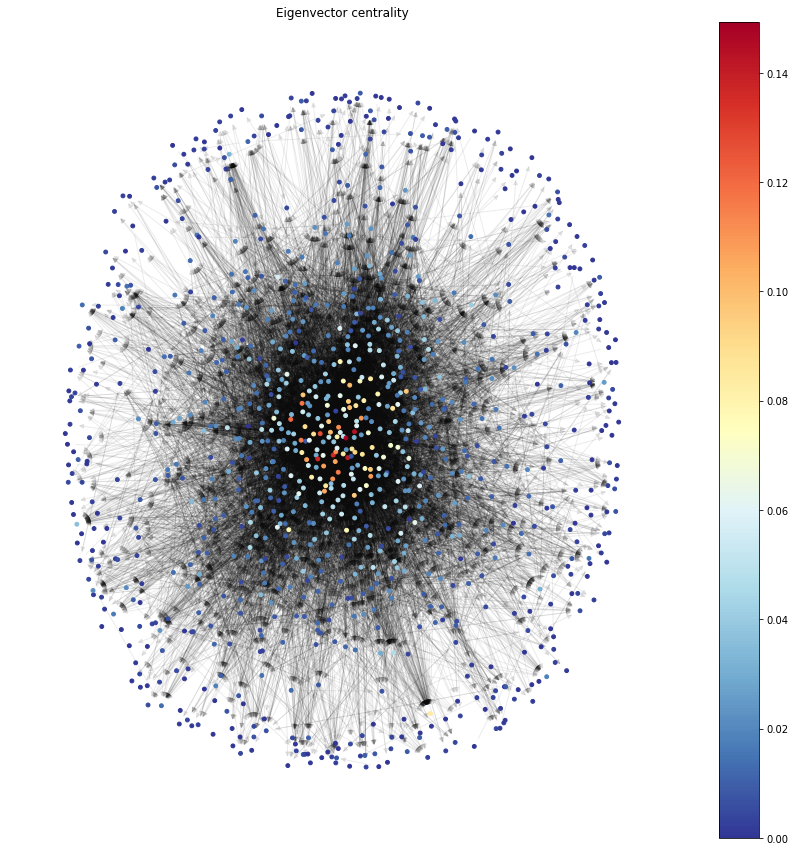

In [ ]:
eigen  = list(nx.eigenvector_centrality(G=G, max_iter=10**6).values())
print(f'min eigen closeness: {min(eigen)}, max eigen closeness:{max(eigen)}')
plt.figure(figsize=(15,15))
nc = nx.draw_networkx_nodes(G, pos, node_size=15, cmap=plt.cm.RdYlBu_r,
                        node_color=eigen)
nx.draw_networkx_edges(G, pos, alpha=0.08)
plt.title('Eigenvector centrality')
plt.axis('off')
plt.colorbar(nc);

### Closeness centrality

min closeness: 0.0, max closeness:0.4496688397114823


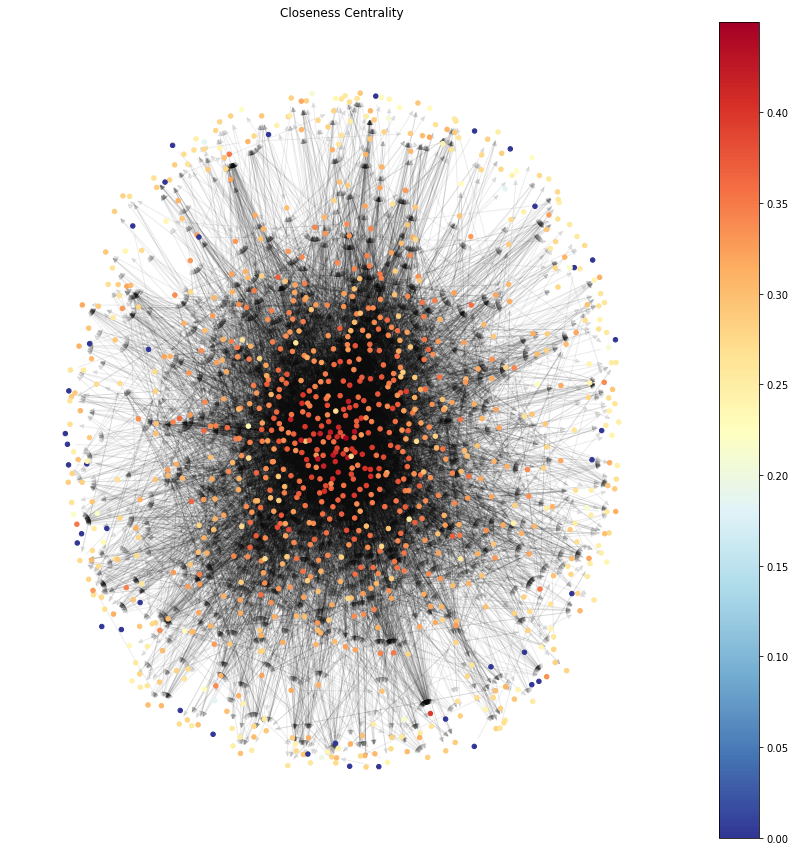

In [ ]:
closeness_centrality = list(nx.closeness_centrality(G).values())
print(f'min closeness: {min(closeness_centrality)}, max closeness:{max(closeness_centrality)}')
plt.figure(figsize=(15,15))
nc = nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu_r,
                        node_color=closeness_centrality)
nx.draw_networkx_edges(G, pos, alpha=0.08)
plt.title('Closeness Centrality')
plt.axis('off')
plt.colorbar(nc);


### Betweenness centrality

min betweenness: 0.0, max betweenness:0.07212078608028884


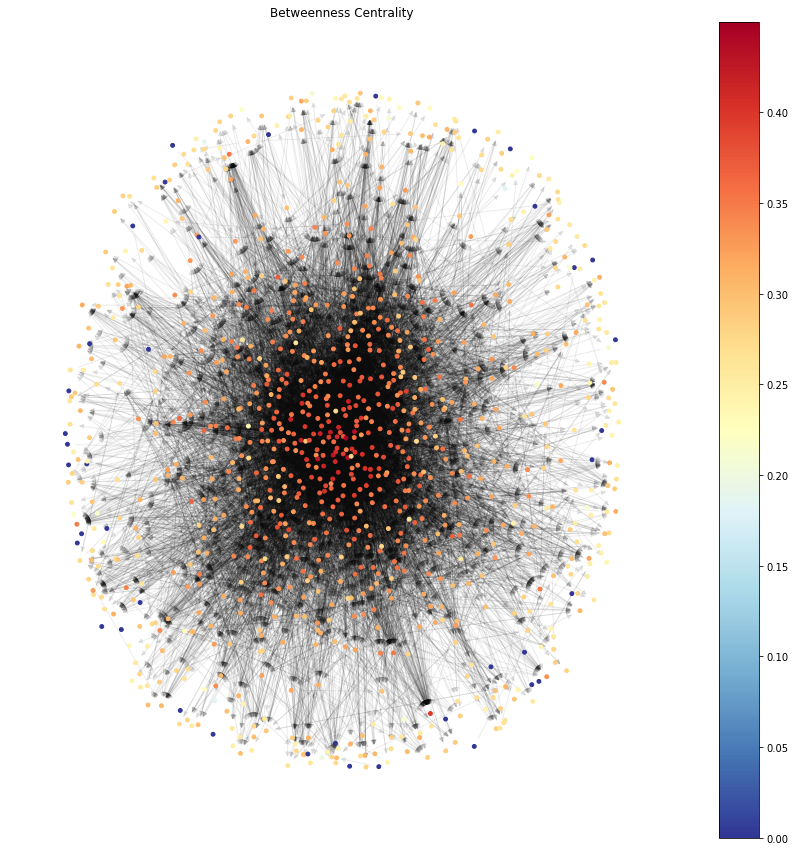

In [ ]:
betweenness_centrality = list(nx.betweenness_centrality(G).values())
print(f'min betweenness: {min(betweenness_centrality)}, max betweenness:{max(betweenness_centrality)}')
plt.figure(figsize=(15,15))
nc = nx.draw_networkx_nodes(G, pos, node_size=15, cmap=plt.cm.RdYlBu_r,
                        node_color=closeness_centrality);
nx.draw_networkx_edges(G, pos, alpha=0.08);
plt.title('Betweenness Centrality');
plt.axis('off');
plt.colorbar(nc);


### Node prediction.

We want to predic the researcher department based on the current interactions with other researchers

In [ ]:
node2vec = Node2Vec(G, dimensions=25, walk_length=16, num_walks=50)
model =  node2vec.fit(window=10, min_count=1, batch_words=4)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]



We used node2vec to predict the resreacher department using the similarity with another nodes

In [ ]:
def find_similar_nodes(node, n, model):
  similars = model.wv.most_similar(str(node), topn=n)
  return [(int(s[0]), s[1]) for s in similars]

In [ ]:
source_node = 2
print("finding similar nodes to", source_node, "that belongs to the department", department_data[int(source_node)])

for node, percentaje in find_similar_nodes(source_node, 5, model):
  print(f"the node {node:4} of the deparment {department_data[node]} is {percentaje*100:.4}% similar.")


finding similar nodes to 2 that belongs to the department 21
the node  899 of the deparment 21 is 96.4% similar.
the node  888 of the deparment 32 is 94.9% similar.
the node 1004 of the deparment 22 is 93.87% similar.
the node  865 of the deparment 21 is 93.61% similar.
the node  993 of the deparment 21 is 93.24% similar.


In [ ]:
def calculate_accuracy(dimensions, walk_length, num_walks, window, min_count, batch_words):

  m =  Node2Vec(G, dimensions, walk_length, num_walks).fit(window=window, min_count=min_count, batch_words=batch_words)
  acc = 0
  sample_per_node = 1
  n_nodes = 1005
  for node in range(n_nodes):
    correct = 0
    department = department_data[node]
    for s in find_similar_nodes(node, sample_per_node, m):
      if department_data[s[0]] == department:
        correct += 1
    acc += correct/sample_per_node
  return acc/n_nodes

In [ ]:
acc = calculate_accuracy(25, 16, 50, 10, 1, 4)
print(f'The accuracy predicting the department of a node is {acc*100:.4}%')

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


The accuracy predicting the department of a node is 69.75%


In [ ]:
performance = []
for k in range(5, 40, 5):
  a = calculate_accuracy(k, 16, 50, 10, 1, 4)
  performance.append((k, a))
  print(f'{k} The accuracy predicting the department of a node is {a*100:.4}%')

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


5 The accuracy predicting the department of a node is 52.54%


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


10 The accuracy predicting the department of a node is 65.17%


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


15 The accuracy predicting the department of a node is 69.55%


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


20 The accuracy predicting the department of a node is 70.55%


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


25 The accuracy predicting the department of a node is 70.65%


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


30 The accuracy predicting the department of a node is 70.25%


Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


35 The accuracy predicting the department of a node is 70.55%


In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=50)
model =  node2vec.fit(window=10, min_count=1, batch_words=4)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


In [ ]:
#node_ids = model.wv.index_to_key 
node_ids = model.wv.index2word
node_embeddings = (
    model.wv.vectors
)

In [ ]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

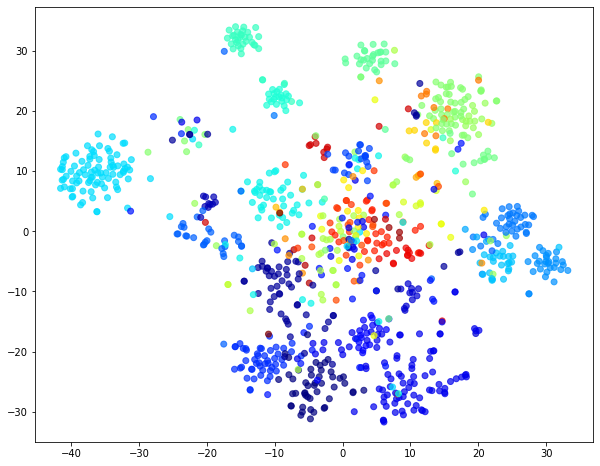

In [ ]:
alpha = 0.7
departments = [department_data[int(node)] for node in node_ids]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=departments,
    cmap="jet",
    alpha=alpha,
);

In [ ]:
X = node_embeddings
y = np.array(departments)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape)
)

Array shapes:
 X_train = (753, 64)
 y_train = (753,)
 X_test = (252, 64)
 y_test = (252,)


In [ ]:
clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring='accuracy',
                     solver='lbfgs', tol=0.0001, verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

# Link Prediction

In [ ]:
edges_csv_emails = pd.read_csv('sample_data/email.csv')
G = nx.from_pandas_edgelist(edges_csv_emails, "from", "to")

### Load the graph

In [ ]:
l = list(G.nodes())
adj_G = nx.to_numpy_matrix(G, nodelist = l)

In [ ]:
# get all node pairs which don't have an edge
non_existing_edges = []
 
offset = 0
for i in tqdm(range(adj_G.shape[0])):
   for j in range(offset,adj_G.shape[1]):
       if i != j:
           if adj_G[i,j] == 0:
                   non_existing_edges.extend([(l[i],l[j])])
 
   offset = offset + 1

print("Non existing edges", len(non_existing_edges))

### Depurate the graph

In [ ]:
nodes_4000 = sorted(random.sample(non_existing_edges, k=40000))

non_existing_edges = [(i[0],i[1]) for i in tqdm(nodes_4000) if nx.has_path(G, i[0], i[1])]

In [ ]:
non_existing_edges_df = pd.DataFrame(data = non_existing_edges, columns =['from', 'to'])
non_existing_edges_df['Connection'] = 0
non_existing_edges_df.head()

,from,to,Connection
0,0,2,0
1,0,10,0
2,0,16,0
3,0,24,0
4,0,31,0


In [ ]:
# Create a list of all indices of the node pairs in the emails dataframe,
# which when removed won’t change the structure of our graph
 
# create a copy
edges_temp = edges_csv_emails.copy()
 
# for storing removable edges
removable_edges_indices = []
 
# number of connected components and nodes of G
ncc = nx.number_connected_components(G)
number_of_nodes = len(G.nodes)
 
# for each node pair we will be removing a node pair and creating a new graph,
# and check if the number of connected components and the number of nodes
# are the same as the original graph
for i in tqdm(edges_csv_emails.index.values):
  
      # remove a node pair and build a new graph
   G1 = nx.from_pandas_edgelist(edges_temp.drop(index= i), "from", "to",
                                create_using=nx.Graph())
  
      # If the number of connected components remain same as the original
      # graph we won't remove the edge
   if (nx.number_connected_components(G1) == ncc) and (len(G1.nodes) == number_of_nodes):
       removable_edges_indices.append(i)
 
       # drop the edge, so that for the next iteration the next G1
       # is created without this edge
       edges_temp = edges_temp.drop(index = i)

100%|██████████| 25571/25571 [15:31<00:00, 27.45it/s] 


In [ ]:
# get node pairs in emails dataframe with indices in removable_edges_indices
removable_edges_df = edges_csv_emails.loc[removable_edges_indices]
 
# create a column 'Connection' and assign default value of 1 (connected nodes)
removable_edges_df['Connection'] = 1
 
removable_edges_df.head()

,from,to,Connection
0,0,1,1
1,2,3,1
2,2,4,1
3,5,6,1
4,5,7,1


In [ ]:
graph_edges = non_existing_edges_df.append(removable_edges_df[['from', 'to', 'Connection']],
                ignore_index=True)
graph_edges.head()

graph_edges['Connection'].value_counts()


0    38408
1    24567
Name: Connection, dtype: int64

In [ ]:
remaining_edges = edges_csv_emails.drop(index=removable_edges_df.index.values)
remaining_edges.head()


,from,to
853,414,449
1374,524,72
1776,462,561
1984,577,578
1996,580,580


In [ ]:
remaining_edges.to_csv('sample_data/remaining_edges.csv')
graph_edges.to_csv('sample_data/graph_edges.csv')
removable_edges_df.to_csv('sample_data/removable_edges.csv')

#remaining_edges = pd.read_csv('sample_data/remaining_edges.csv')
#graph_edges = pd.read_csv('sample_data/graph_edges.csv')
#removable_edges_df = pd.read_csv('sample_data/removable_edges.csv')



In [ ]:
G_new = nx.from_pandas_edgelist(remaining_edges, "from", "to",
                               create_using=nx.Graph())

print(nx.info(G_new))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 1004
Average degree:   1.9980


In [ ]:

# Generating walks
node2vec = Node2Vec(G_new, dimensions=100, walk_length=16, num_walks=50)
 
# training the node2vec model
n2v_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


In [ ]:
edge_features = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(graph_edges['from'], graph_edges['to'])]

In [ ]:
X = np.array(edge_features)
y = graph_edges['Connection']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


### Models

In [ ]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_test)
roc_auc_score(y_test, predictions[:,1])


In [ ]:
rdmf = RandomForestClassifier(n_estimators=100, max_depth=15)

rdmf.fit(X_train, y_train)
predictions = rdmf.predict_proba(X_test)
roc_auc_score(y_test, predictions[:,1])

[[0.72, 0.64]]


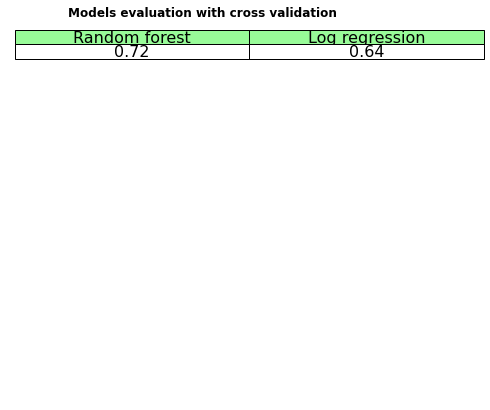

In [ ]:
def evaluate_model_cross_val(model, X, y):
    scores = cross_val_score(model, X, y, cv=5)
    accuracy = np.average(scores)
    return scores, accuracy
def run_model_comparison():
    
    results = [[]]
    models = { "Random forest": rdmf, "Log regression": lr }
    for k in models.keys():
        score, accuracy = evaluate_model_cross_val(models[k], X, y)
        results[0].append(round(accuracy, 2))
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    ax.set_axis_off()
    print(results)
    table = ax.table(
        cellText = results,  
        colLabels = list(models.keys()), 
        colColours =["palegreen"] * 10, 
        cellLoc ='center',  
        loc ='upper left')
    table.set_fontsize(16)
    table.scale(1.2, 1.2)
    ax.set_title('Models evaluation with cross validation', fontweight ="bold")
    plt.show()

    
run_model_comparison()

In [ ]:
n2v_model.save('sample_data/node2vec_link_pred_model_f_20.txt')

# Confusion Matrix

In [ ]:
def visualize_consusion_matrix(cnf_matrix, name):
    class_names = [0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion matrix {name}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    


Accuracy: 0.6587271341463414
Precision: 0.6077162092180217
Recall: 0.3782433521353747


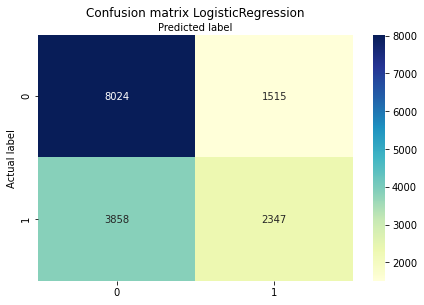

In [ ]:
y_pred = lr.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
visualize_consusion_matrix(cnf_matrix, 'LogisticRegression')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.7968114837398373
Precision: 0.8609510086455331
Recall: 0.5777598710717163


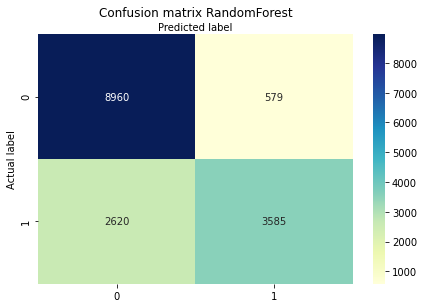

In [ ]:
y_pred = rdmf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
visualize_consusion_matrix(cnf_matrix, "RandomForest")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


### Predict a link for two nodes

In [ ]:
non_existing_edges_df.head()


,from,to,Connection
0,0,2,0
1,0,10,0
2,0,16,0
3,0,24,0
4,0,31,0


In [ ]:
print("let's try to predict a link between node 0 and 56")

let's try to predict a link between node 0 and 56


In [ ]:

print(f'Index of ({graph_edges.iloc[4,0]},{graph_edges.iloc[4,1]}) node pair in X_train : {np.where(X_train == X[4])[0][1]}')
print(f' ({graph_edges.iloc[4,0]},{graph_edges.iloc[4,1]}) node pair features : {X[4]}')

Index of (0,31) node pair in X_train : 15027
 (0,31) node pair features : [ 0.5599792  -0.02288011 -0.04041945 -0.9924756  -0.64472723 -0.44483608
  1.0118487  -1.2607263   0.40222165  0.88917994  0.12426099  0.9088887
 -0.73397535  0.7429452   0.8921548   0.02840815 -0.74917555  0.460761
  0.17411053 -0.4121018  -0.5162039  -0.22107661 -0.51858765 -0.17075954
  0.44737542  0.02629071  0.18630204 -0.20698223 -0.67602146  0.34124848
 -1.331512    0.03398372 -0.7836905   0.8725295   0.2766176  -0.92610157
 -0.89202595 -0.5442748  -0.54983306 -0.12815018 -0.01096946 -1.0139037
  0.01221216  0.36886227 -1.1001942   1.408809   -0.5392064   0.19797763
  0.20442045  0.23530233  0.22404224 -0.34190357  0.2059454   1.3032165
 -1.0426557   0.6435534  -0.13545     0.00693036 -0.02717929  0.48400354
 -0.38925755  1.1290017   0.3720234  -0.47953558 -0.96563536  0.13954985
 -0.42944807 -0.4113357   0.3319008   0.11651075 -0.90011823  0.223933
  1.0719777  -0.5358666   0.6123235  -0.9176458  -0.61233

In [ ]:
predict_proba = rdmf.predict_proba(np.where(X_train == X[4]))[0][1]
 
print(f'Probability of nodes {graph_edges.iloc[4,0]} and {graph_edges.iloc[4,1]} to form a link is : {float(predict_proba)*100 : .2f}%')

Probability of nodes 0 and 31 to form a link is :  51.00%
